In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import xarray as xr

%matplotlib inline
az.rcParams["stats.hdi_prob"] = 0.89
az.style.use("bmh")

In [2]:
#%% Read data from csv and do the regression.
howell = pd.read_csv('Data/Howell1.csv', sep=';')
adults = howell[howell.age >= 18]

#%% Regression weight ~ height.
height_bar = adults.height.mean()
with pm.Model() as weight_model:
    adults_height = pm.Data('adults_height', adults.height.values)
    a = pm.Normal("a", 60, 10)
    b = pm.Lognormal("b", 0, 1)
    sigma = pm.Uniform("sigma", 0, 10)
    mu = a + b * (adults_height - height_bar)    
    w = pm.Normal("weight", mu, sigma, observed=adults.weight.values)
    idata = pm.sample()    

az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/telescreen/miniconda3/envs/data/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]
/home/telescreen/miniconda3/envs/data/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,44.996,0.231,44.609,45.345,0.003,0.002,5415.0,3081.0,1.0
b,0.629,0.030,0.581,0.677,0.000,0.000,5205.0,2668.0,1.0
sigma,4.255,0.163,4.009,4.518,0.002,0.002,5597.0,2810.0,1.0


In [3]:
with weight_model:
    weight_pred = pm.sample_posterior_predictive(idata)

Text(0, 0.5, 'weight')

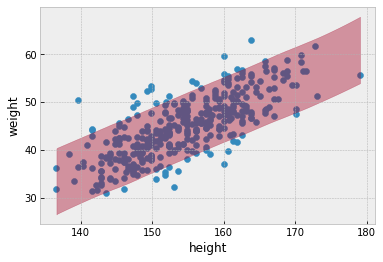

In [4]:
plt.scatter(adults.height, adults.weight)
az.plot_hdi(adults.height, weight_pred.posterior_predictive['weight'], 
            fill_kwargs={'alpha':0.4})
plt.xlabel('height')
plt.ylabel('weight')

### Predict using set_data

In [5]:
with weight_model:
    pm.set_data({'adults_height': [140, 160, 175]})
    weight_pred = pm.sample_posterior_predictive(idata)

In [6]:
weight_pred.posterior_predictive.weight.mean(dim=['chain', 'draw']).values

array([35.74780881, 48.33125565, 57.90549215])

In [7]:
az.hdi(weight_pred.posterior_predictive).weight.values

array([[28.20968976, 41.7912933 ],
       [41.27680525, 54.72029058],
       [50.88347476, 64.51552654]])

### Predict using sampling

In [8]:
input_height = np.array([140, 160, 175])
for height in input_height:
    draw = stats.norm.rvs(
        loc=idata.posterior['a'] + idata.posterior['b']*(height - height_bar),
        scale=idata.posterior['sigma']).reshape(-1)
    wmean = draw.mean()
    whdi = az.hdi(draw)
    print("{} {:0.2f} {:0.2f} {:.2f}".format(height, wmean, whdi[0], whdi[1]))

140 35.90 28.87 42.47
160 48.35 41.75 55.06
175 57.82 50.64 64.42


## Under 13 Predicting

In [9]:
under13 = howell[howell.age < 13]
under13.describe()

,height,weight,age,male
count,146.000000,146.000000,146.000000,146.000000
mean,98.810729,14.693328,5.401370,0.486301
std,21.489527,5.722741,3.824657,0.501533
min,53.975000,4.252425,0.000000,0.000000
25%,84.455000,10.829509,2.000000,0.000000
50%,98.844100,13.792032,5.000000,0.000000
75%,114.300000,18.335039,8.000000,1.000000
max,147.955000,32.488527,12.000000,1.000000


In [10]:
with pm.Model() as age_model:
    data = pm.Data('observed_weight', under13.weight)
    a = pm.Normal("a", 5, 1)
    b = pm.Lognormal("b", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    mu = a + b * under13.age.values
    w = pm.Normal("weight", mu, sigma, observed=data)
    idata_age = pm.sample()
    
az.summary(idata_age, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/telescreen/miniconda3/envs/data/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]
/home/telescreen/miniconda3/envs/data/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,7.16,0.35,6.58,7.70,0.01,0.01,1934.03,2463.21,1.0
b,1.38,0.05,1.29,1.46,0.00,0.00,2051.63,2243.80,1.0
sigma,2.55,0.15,2.30,2.77,0.00,0.00,2392.77,2100.70,1.0


In [11]:
sdx = under13.male.values
with pm.Model() as age_model2:
    age = pm.Data("Age", under13.age.values)
    sex = pm.Data("Sex", under13.male.values)
    a = pm.Normal("a", 5, 1, shape=2)
    b = pm.Lognormal("b", 0, 1, shape=2)
    sigma = pm.Exponential("sigma", 1)
    mu = a[sex] + b[sex] * age
    w = pm.Normal("weight", mu, sigma, observed=under13.weight)
    idata_age2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/telescreen/miniconda3/envs/data/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]
/home/telescreen/miniconda3/envs/data/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [12]:
az.summary(idata_age2, var_names=['a', 'b', 'sigma'], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],6.69,0.44,6.05,7.46,0.01,0.01,2597.67,2599.23,1.0
a[1],7.30,0.48,6.51,8.03,0.01,0.01,2650.47,2050.26,1.0
b[0],1.33,0.07,1.22,1.44,0.00,0.00,2661.53,2575.45,1.0
b[1],1.46,0.08,1.34,1.58,0.00,0.00,2438.54,1892.84,1.0
sigma,2.47,0.15,2.24,2.70,0.00,0.00,2670.17,2176.75,1.0


In [15]:
AgeSeq = xr.DataArray(np.arange(0,13), dims='plot')
mu = idata_age2.posterior['a'] + idata_age2.posterior['b'] * AgeSeq
muG = mu.sel(a_dim_0=0, b_dim_0=0)
muB = mu.sel(a_dim_0=1, b_dim_0=1)

In [17]:
muG_mean = muG.mean(dim=['chain', 'draw'])
muB_mean = muB.mean(dim=['chain', 'draw'])

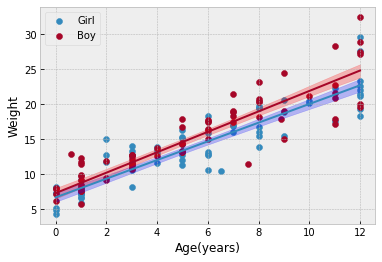

In [18]:
plt.scatter(under13.age[under13.male==0], under13.weight[under13.male==0], label='Girl')
plt.scatter(under13.age[under13.male==1], under13.weight[under13.male==1], label='Boy')
plt.xlabel("Age(years)")
plt.ylabel("Weight")
plt.plot(AgeSeq, muG_mean)
plt.plot(AgeSeq, muB_mean)
az.plot_hdi(AgeSeq, muG, color='b', fill_kwargs={'alpha': 0.25})
az.plot_hdi(AgeSeq, muB, color='r', fill_kwargs={'alpha': 0.25})
plt.legend()

In [19]:
def sim_weight(age: xr.DataArray):    
    girl = np.zeros(len(age), dtype=np.int64)
    boy = np.ones(len(age), dtype=np.int64)
    with age_model2:
        pm.set_data({'Age': age, 'Sex': girl})
        weightG = pm.sample_posterior_predictive(idata_age2)
        pm.set_data({'Age': age, 'Sex': boy})
        weightB = pm.sample_posterior_predictive(idata_age2)
    return (weightG.posterior_predictive.weight, weightB.posterior_predictive.weight)

In [22]:
weightG, weightB = sim_weight(AgeSeq)

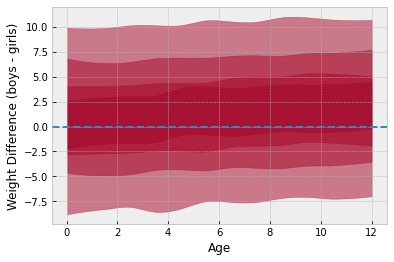

In [32]:
contrast = weightB - weightG
hdi_probs = [0.5, 0.67, 0.89, 0.99]
for hdi_prob in hdi_probs:
    az.plot_hdi(AgeSeq, contrast, hdi_prob=hdi_prob)
plt.axhline(xmin=0, xmax=12, linestyle='--')
plt.xlabel('Age')
plt.ylabel('Weight Difference (boys - girls)');